# Show the impact of changing the data distribution on the Model


We will build on top of the "House Prices" dataset and the example used in the famous Coursera "Machine Learning" course by Andrew Ng and we will:
1. Show ideal trained parameters for the linear regression model


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import unittest

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
rcParams['animation.embed_limit'] = 2**128

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

In [2]:
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


Getting the  basic data discriptive statistics

In [4]:
df_train = pd.read_csv('house_prices_train.csv')
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


We will look into descriptive statistics for "SalePrice", the target we want to predict

In [5]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

C:\Users\pvipl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


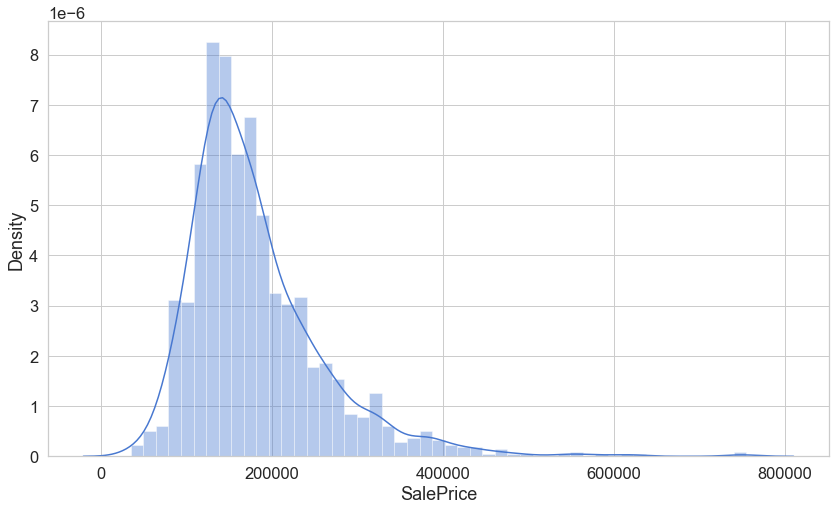

In [6]:
sns.distplot(df_train['SalePrice']);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


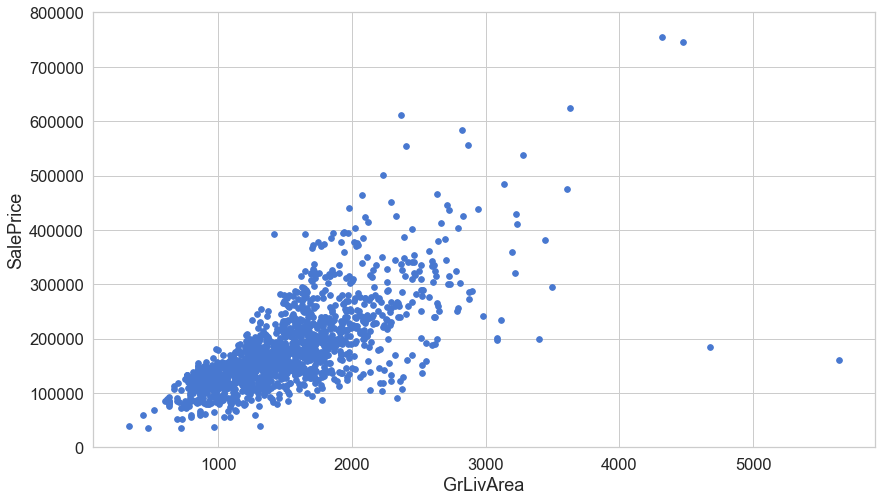

In [7]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000), s=32);

To understand the impact of Data Distribution, we create a division in data with respect to time, before and after "YearBuilt" of 2000

In [8]:
df_new = df_train[df_train.YearBuilt > 2000]
df_old = df_train[df_train.YearBuilt <= 2000]

In [9]:
cumul_x = df_train['GrLivArea']
cumul_y = df_train['SalePrice']

# x = (x - x.mean()) / x.std()
cumul_x = np.c_[np.ones(cumul_x.shape[0]), cumul_x] 

cumul_x.shape

(1460, 2)

In [13]:
def loss(h, y):
    sq_error = (h - y)**2
    n = len(y)
    return 1.0 / (2*n) * sq_error.sum()

In [14]:
class LinearRegression:
    def _gradient_descent_step(self, X, targets, lr):
        predictions = self.predict(X)
    
        error = predictions - targets
        gradient = np.dot(X.T,  error) / len(X)

        self._W -= lr * gradient
    def __init__(self):
        self._W = np.zeros(2)
        self._cost_history = []
        self._w_history = [self._W]
    def predict(self, X):
        return np.dot(X, self._W)

        
    def fit(self, X, y, n_iter=100000, lr=0.01):
        for i in range(n_iter):
            prediction = self.predict(X)
            cost = loss(prediction, y)

            self._cost_history.append(cost)

            self._gradient_descent_step(X, y, lr)

            self._w_history.append(self._W.copy())

        return self

Parameters learnt on taking all the data

In [15]:
cumul_clf = LinearRegression()
cumul_clf.fit(cumul_x, cumul_y, n_iter=150, lr=1e-7)

cumul_clf._W

array([9.94290254e-02, 1.18069042e+02])

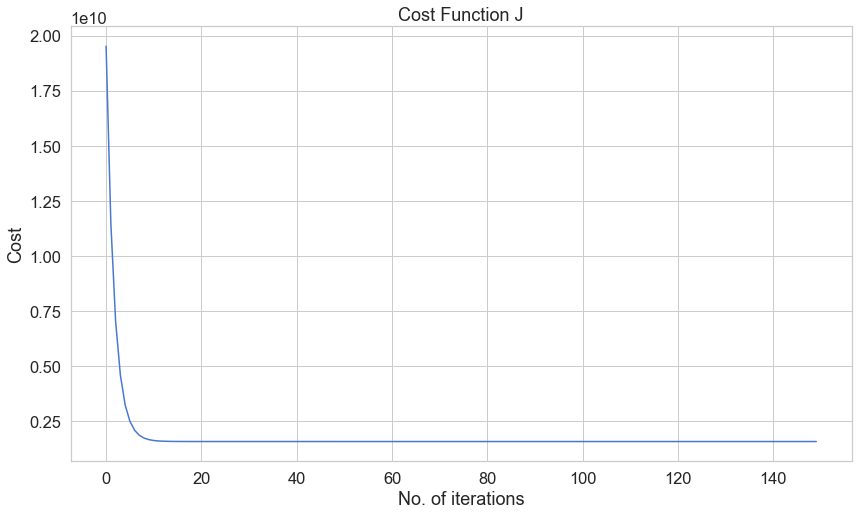

In [16]:
plt.title('Cost Function J')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(cumul_clf._cost_history)
plt.show()

In [17]:
x_old = df_old['GrLivArea']
y_old = df_old['SalePrice']

x_old = np.c_[np.ones(x_old.shape[0]), x_old] 

x_old.shape

(1096, 2)

In [18]:
x_new = df_new['GrLivArea']
y_new = df_new['SalePrice']

x_new = np.c_[np.ones(x_new.shape[0]), x_new] 

x_new.shape

(364, 2)

In [22]:
model_old = LinearRegression()
model_old.fit(x_old, y_old, n_iter=150, lr=1e-7)

model_old._W

array([1.03397202e-01, 1.08036794e+02])

In [23]:
model_new = LinearRegression()
model_new.fit(x_new, y_new, n_iter=150, lr=1e-7)

model_new._W

array([  0.15168198, 141.32532501])

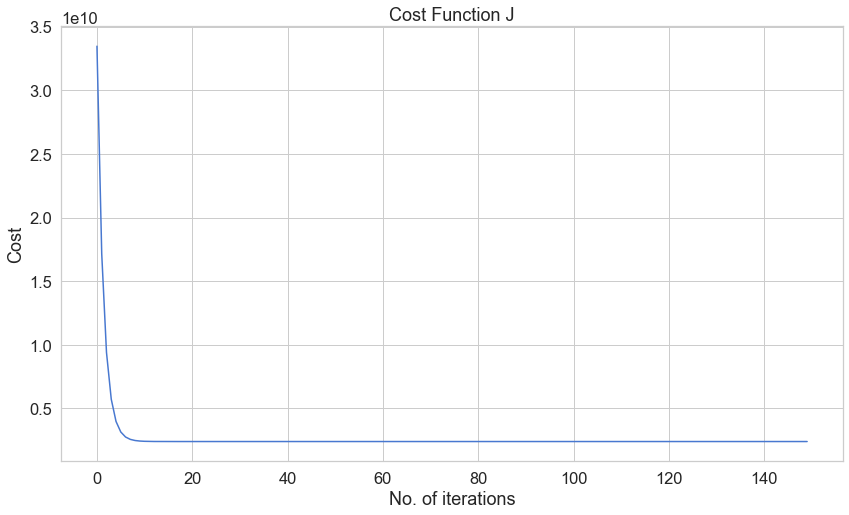

In [24]:
plt.title('Cost Function J')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(model_new._cost_history)
plt.show()

The change in loss function between the model learnt on all the data and the one with just the new data are different and so are the estimate parameters